<h2>Computation of k<sub>cat</sub>/K<sub>M</sub> values for over 200,000 FltJ<sub>A</sub> substrates from NGS data<br><i>DOMEK pipeline walkthough</i></h2>

This notebook reproduces DOMEK computational pipeline. The code below can be used to determine k<sub>cat</sub>/K<sub>M</sub> values for FltJ<sub>A</sub> substrates from NGS data. The code was built and tested for

python 3.8.5<br>
numpy 1.19.5<br>
pandas 1.2.4<br>
rdkit 2021.03.3<br>
tensorflow 2.4.1<br>
tensorflow-io 0.17.1<br>
h5py 2.10.0<br>
matplotlib 3.3.4<br>

`../environment/clibas_env.yml` is the conda environment file which can be used to quickly set up the environemnt.

Everywhere in the code, npAA abbreviations are as follows: `d` = Dha; `a` = N<sup>Me</sup>Ala. This encoding differs from the one used in the accompanying manuscript where Dha was encoded as `u`.

To reproduce the code below, merged R1/R2 NGS files can be added to `../sequencing_data` to start. The files are big (>20 Gb) and are not stored in this repo. They can be downloaded from [Zenodo](https://zenodo.org/records/15315649) (doi: 10.5281/zenodo.15315649).

<h3>Parse .fastq files</h3>

We begin by setting up the parser. We use a modified/improved version of `clibas`, a python library for the analysis of mRNA display-derived NGS data to parse .fastq.gz Illumina NGS files. 

In [1]:
import gc, warnings, re, os
warnings.simplefilter(action='ignore')

import numpy as np
np.set_printoptions(suppress=True, precision=3)

import pandas as pd
from numba import njit
from copy import deepcopy

from clibas.parsers import FastqParser
from clibas.pipelines import Pipeline
from clibas.dataanalysis import DataAnalysisTools
from clibas.dispatchers import Dispatcher
from clibas.datapreprocessors import DataPreprocessor
from clibas.datatypes import AnalysisSample, Data

#initialize parser objects
pip, par, dta, pre = Dispatcher.dispatch('DOMEK_config.yaml', 
                                         (Pipeline, 
                                          FastqParser, 
                                          DataAnalysisTools, 
                                          DataPreprocessor
)
)

[INFO]: <class 'clibas.pipelines.Pipeline'> was succesfully initialized
[INFO]: <class 'clibas.parsers.FastqParser'> was succesfully initialized
[INFO]: <class 'clibas.dataanalysis.DataAnalysisTools'> was succesfully initialized
[INFO]: <class 'clibas.datapreprocessors.DataPreprocessor'> was succesfully initialized


`DOMEK_config.yaml` is a config file that holds the information about the design of r.rec.8m8 library, the details of genetic code reprogramming and other metadata. This information is needed to set up the .fastq parser.

Now we build a parser pipeline which will fetch .fastq.gz files located in `../sequencing_data` (as specified in the config file), trim NGS adapter sequences, run in silico translation, and then filter out noise, frameshifted peptides, overly mutated sequences, entries with insufficiently high Phred scores, etc.

The process of building `clibas` parser pipelines is explained in https://github.com/avngrdv/clibas.

In [2]:
#create a pipeline
pip.enque([
           par.trim_reads(left='ATGAGT', right='CGGAAA'),
           par.translate(force_at_frame=0, stop_readthrough=False),
           dta.length_analysis(where='pep', save_txt=True),
           par.len_filter(where='pep'),
           par.cr_filter(where='pep', loc=[0, 2], tol=5),
           par.vr_filter(where='pep', loc=[1], sets=[1, 2, 3]),
           dta.q_score_analysis(save_txt=True),
           par.q_score_filt(minQ=23, loc=[1]),
           par.fetch_at(where='pep', loc=[1]),
           par.filt_ambiguous(where='pep'),
           par.count_summary(where='pep', top_n=5000, fmt='csv'),
           par.unpad(),
           par.save(where='pep', fmt='npy')
]
)

[INFO]: 13 ops appended to pipeline; current queue size: 13


Now we run the pipeline to parse the data. The files are big (0.5-1 Gb), and the pipeline is RAM intensive. The operation below could be run with 64 Gb RAM, but the files may need to be split in several chunks on smaller machines. 

For this demo, the folder contains just one .gz file, which will not be provided in the final repo due to size. Download .gz files from [Zenodo](https://zenodo.org/records/15315649) (doi: 10.5281/zenodo.15315649).

In [3]:
#execute the pipeline, one .gz file at a time
pip.stream(generator=par.stream_from_gz_dir(), 
           save_summary=True
)

[INFO]: Fetching p4_c008_t540_FT_m.gz. . .
[INFO]: p4_c008_t540_FT_m dna dataset shape: (24840117,)
[INFO]: p4_c008_t540_FT_m Q dataset shape: (24840117,)
[INFO]: p4_c008_t540_FT_m pep dataset shape: None
[INFO]: -----------------------------------------------------------------
[INFO]: Queuing <trim> op. . .
[INFO]: The operation took 119.976 s
[INFO]: p4_c008_t540_FT_m dna dataset shape: (24840117,)
[INFO]: p4_c008_t540_FT_m Q dataset shape: (24840117,)
[INFO]: p4_c008_t540_FT_m pep dataset shape: None
[INFO]: -----------------------------------------------------------------
[INFO]: Queuing <translate_dna> op. . .
[INFO]: The operation took 1454.85 s
[INFO]: p4_c008_t540_FT_m dna dataset shape: (24840117, 290)
[INFO]: p4_c008_t540_FT_m Q dataset shape: (24840117, 290)
[INFO]: p4_c008_t540_FT_m pep dataset shape: (24840117, 93)
[INFO]: -----------------------------------------------------------------
[INFO]: Queuing <length_summary> op. . .
[INFO]: The operation took 52.409 s
[INFO]: p

A folder that holds parser results is created in `../parser_outputs`.

The resulting peptide lists are stored in `../parser_outputs/<sample_name>/<sample_name>_pep.npy` as .npy files. The output folders also contain other useful information. 

We will now move peptide lists to a dedicated folder: `../npy files`. The combined 32 peptide lists are >60 Gb in size at this point; they will not be stored in this repo.

In [4]:
from clibas.misc import fetch_npy_files
fetch_npy_files(source='../parser_outputs', destination='../NGS sample npys')

Now we process individual (<i>e<sub>0</sub></i>, <i>t</i>) data points. Each data point is associated with 2 peptide lists, one for the "reacted" (here referred to as positive) and "unreacted" (negative).

The code below universally refers to <i>e<sub>0</sub></i> values as <i>c</i>. 

<h3>Process individual (<i>e<sub>0</sub></i>, <i>t</i>) data points</h3>

In [5]:
from DOMEK import compute_pep_freq, compute_yields, compute_yield_SEMS_v3

In [6]:
C_DICT = {8: '800', 0.8: '080', 0.08: '008', 0: '000'}
meta = pd.read_csv(os.path.join('../other/DOMEK_Table_S4.csv'))

#make a folder to write outputs in
if not os.path.isdir('../sample dataframes'):
    os.makedirs('../sample dataframes')  

#iterate over pulldowns
for row in meta.iterrows():
    exp = row[1]
    t = int(exp['t'])
    c = exp['c']
    r = exp['r'] 
    dr = exp['dr']
    
    #load a pair of datasets and analyze them together
    try:
        pos = np.load(os.path.join('../NGS sample npys', f'p4_c{C_DICT[c]}_t{t}_FT_m_pep.npy'))
        neg = np.load(os.path.join('../NGS sample npys', f'p4_c{C_DICT[c]}_t{t}_E_m_pep.npy'))
    except:
        raise
        
    print(f'Working on the c={C_DICT[c]} t={t} sample. . .')
        
    #get the individual pos and neg frequency lists
    df_pos = compute_pep_freq(pos, kind='pos')
    df_neg = compute_pep_freq(neg, kind='neg')
    
    #merge them
    df_m = pd.merge(df_pos, df_neg, on='seq', how='outer')
    df_m = df_m.sort_values('seq', ascending=True)
    
    #deal with nans: just fill the missing entries with zeros
    df_m = df_m.fillna(0)

    df_m['t'] = t
    df_m['c'] = c
    df_m['r'] = r
    df_m['dr'] = dr
    
    #calculate yields
    df_m['y'] = compute_yields(df_m['pos_freq'],
                                df_m['neg_freq'],
                                df_m['r']
)       
    #calculate yield SEs   
    df_m['y_err'] = compute_yield_SEMS_v3(df_m['pos_freq'], 
                                          df_m['neg_freq'], 
                                          df_m['pos_count'].sum(), 
                                          df_m['neg_count'].sum(), 
                                          df_m['r'],
                                          df_m['dr'],
)
    #save these intermediate results        
    df_m.to_csv(os.path.join('../sample dataframes',
                              f'p4_c{C_DICT[c]}_t{t}_summary.csv'
                            ), index=False
)

Working on the c=000 t=0 sample. . .
Working on the c=000 t=15 sample. . .
Working on the c=000 t=90 sample. . .
Working on the c=000 t=540 sample. . .
Working on the c=008 t=0 sample. . .
Working on the c=008 t=15 sample. . .
Working on the c=008 t=90 sample. . .
Working on the c=008 t=540 sample. . .
Working on the c=080 t=0 sample. . .
Working on the c=080 t=15 sample. . .
Working on the c=080 t=90 sample. . .
Working on the c=080 t=540 sample. . .
Working on the c=800 t=0 sample. . .
Working on the c=800 t=15 sample. . .
Working on the c=800 t=90 sample. . .
Working on the c=800 t=540 sample. . .


Code above creates summary spreadsheets for each (<i>e<sub>0</sub></i>, <i>t</i>) data point. The summary contains peptide sequences and the associated read counts as well as uncorrected yields at this point. We now need to consolidate the data and assemble a master list of peptides which have reads in every sample. Only the peptides from this master list will be used for fitting later on.

<h3>Assemble a master list of peptides</h3>

In [7]:
parent = '../sample dataframes'
DFs = []
fnames = []

#make a folder to write outputs in
if not os.path.isdir('../sample dataframes'):
    os.makedirs('../sample dataframes')  

#get a list of datasets (samples) to concatenate
for f in os.listdir(parent):
    full_path = os.path.join(parent, f)
    if os.path.isfile(full_path) and full_path.endswith('_summary.csv'):
        DFs.append(pd.read_csv(full_path)) 
        fnames.append(full_path)

#initialize the master dataframe 
time = int(re.search(r't(\d+)', fnames[0])[0][1:])
conc = re.search(r'c(\d+)', fnames[0])[0][1:]   
suffix = f'_c{conc}_t{time}'

master = DFs[0][['seq', 'pos_count', 'neg_count']]
master['count_sum'] = master['pos_count'] + master['neg_count']
master.rename(columns={'pos_count': 'pos_count' + suffix,
                       'neg_count': 'neg_count' + suffix,
                       'count_sum': 'count_sum' + suffix
                      }, inplace=True
)

#merge the read count information
for df, fname in zip(DFs[1:], fnames[1:]):
    
    time = int(re.search(r't(\d+)', fname)[0][1:])
    conc = re.search(r'c(\d+)', fname)[0][1:]   
    suffix = f'_c{conc}_t{time}'
    
    trunc_df = df[['seq', 'pos_count', 'neg_count']]
    trunc_df['count_sum'] = trunc_df['pos_count'] + trunc_df['neg_count']    
    trunc_df.rename(columns={'pos_count': 'pos_count' + suffix,
                              'neg_count': 'neg_count' + suffix,
                              'count_sum': 'count_sum' + suffix,
                            }, inplace=True
)   
    #use an outer merge procedure
    master = pd.merge(master, 
                      trunc_df,
                      on='seq', 
                      how='outer',
                      suffixes=(None, None)
)

#deal with nans: just fill the missing entries with zeros
master = master.fillna(0)

#drop a sequence if any of the 'count_sum' values is zero
#in other words, only keep the peptides which have at least
#one read in all (c,t) NGS samples
col = [c for c in master.columns if c.startswith('count_sum')]
mask = (master[col] >= 1).all(axis=1)

master = master[mask]
master.to_csv(os.path.join(parent, 'DOMEK_master_list_pep.csv'), index=False)

#go through individual summary spreadsheets and assemble 
#subsets containing only master sequences
for df, fname in zip(DFs, fnames):
    
    filtered_df = df[df['seq'].isin(master['seq'])]
    name = os.path.split(fname)[-1].split('.')[0] 
    filtered_df.to_csv(os.path.join(parent, f'{name}_only_master_seq.csv'),
                       index=False
)

<h3>Next, introduce yield corrections and compute yield SEs</h3>

In [8]:
parent = '../sample dataframes'
meta = pd.read_csv(os.path.join('../other/DOMEK_Table_S4.csv'))
ETA = 1e-8 #small non-zero value to avoid infinities

#make a folder to write outputs in
if not os.path.isdir(parent + '/corrected'):
    os.makedirs(parent + '/corrected')  

#compute f_neg correction factors
d_min = pd.read_csv(os.path.join(parent, 'p4_c000_t0_summary_only_master_seq.csv'))
d_max = pd.read_csv(os.path.join(parent, 'p4_c800_t540_summary_only_master_seq.csv'))
    
#the condition specifying the minimal observed neg_freq to consider
ind = (d_max['y'] > 0.95) & (d_max['y_err'] < 0.10)

q = (d_max[ind]['neg_freq'] * (1 - d_max[ind]['r']) / (d_min[ind]['neg_freq'] * (1 - d_min[ind]['r'])))
q = q[q < 0.5].mean()
   
neg_freq_r_corrections = q * d_min['neg_freq'] * (1 - d_min['r'])

#fetch dataset names to correct
DFs = []
fnames = []
for f in os.listdir(parent):
    full_path = os.path.join(parent, f)
    if os.path.isfile(full_path) and full_path.endswith('_summary_only_master_seq.csv'):
        DFs.append(pd.read_csv(full_path)) 
        fnames.append(full_path)
        
#introduce corrections sample by sample
for df, fname in zip(DFs, fnames):

    #1. correct the negative freqs
    df['neg_freq_corr'] = (df['neg_freq'] * (1 - df['r']) - neg_freq_r_corrections)/(1 - df['r'] - q * (1 - d_min['r']))
    #make sure we don't have negative or zero frequencies
    df = df.fillna(ETA)
    df['neg_freq_corr'][df['neg_freq_corr'] <= ETA ] = ETA
     
    #2. correct positive freqs (3-point correction)
    time = int(re.search(r't(\d+)', fname)[0][1:])
    conc = re.search(r'c(\d+)', fname)[0][1:]
    
    d_c_0 = pd.read_csv(os.path.join(parent, f'p4_c{conc}_t0_summary_only_master_seq.csv'))
    d_0_0 = pd.read_csv(os.path.join(parent, 'p4_c000_t0_summary_only_master_seq.csv'))
    d_0_t = pd.read_csv(os.path.join(parent, f'p4_c000_t{time}_summary_only_master_seq.csv'))

    df['pos_freq_corr'] = (df['pos_freq'] * df['r'] - d_c_0['pos_freq'] * d_c_0['r'] -
                           d_0_t['pos_freq'] * d_0_t['r'] + d_0_0['pos_freq'] * d_0_0['r']) / (df['r'] - d_c_0['r'] - d_0_t['r'] + d_0_0['r'])

    #make sure we don't have negative or zero frequencies
    df = df.fillna(ETA)
    df['pos_freq_corr'][df['pos_freq_corr'] <= ETA ] = ETA
      
    #3. recalculate the yields and errors
    #calculate corrected yields
    df['y_corr'] = compute_yields(df['pos_freq_corr'],
                                  df['neg_freq_corr'],
                                  df['r']
)       
    
    #calculate corrected yield sems   
    df['y_err_corr'] = compute_yield_SEMS_v3(df['pos_freq_corr'], 
                                              df['neg_freq_corr'], 
                                              df['pos_count'].sum(), 
                                              df['neg_count'].sum(), 
                                              df['r'],
                                              df['dr'],
)
    
    #deal with nans: just fill the missing entries with zeros
    df = df.fillna(0)
    
    #save corrected datasets
    name = os.path.split(fname)[-1].split('.')[0] 
    df.to_csv(os.path.join(parent, 'corrected', f'{name}_corrected.csv'), index=False)

<h3>Conduct the fitting, peptide by peptide, to determine their k<sub>cat</sub>/K<sub>M</sub> values</h3>

We fit to both 2- and 1-parameter equations here (refer to the manuscript for the details regarding kinetic equations). This step will need to be reimplmented in the future, because `curve_fit` is too slow. 

In [11]:
from DOMEK import tQSSA_2param, tQSSA_1param, calculate_r2_adj

In [12]:
MIN_ERR = 0.01

#make a folder to write outputs in
if not os.path.isdir('../kinetics fitting'):
    os.makedirs('../kinetics fitting')  

from scipy.optimize import curve_fit
parent = os.path.join('../sample dataframes', 'corrected')
DFs = []

#since every file contains master dataset peptides only,
#the sequence lists are identical in every file
peps = list(pd.read_csv(os.path.join(
                        parent, 'p4_c000_t0_summary_only_master_seq_corrected.csv')
                       )['seq']
)

for f in os.listdir(parent):
    full_path = os.path.join(parent, f)
    if os.path.isfile(full_path) and full_path.endswith('_summary_only_master_seq_corrected.csv'):
        
        #(0, t) data are only used for referencing, 
        #no use for fitting, so these files are not fetched
        if not'_c000_' in full_path and f.startswith('p4'):
            DFs.append(pd.read_csv(full_path)) 
            
fits = []
counter = 0

for pep in peps:
    
    #assemble a dataframe containing pep-specific data
    pep_data = []
    for df in DFs:
        pep_data.append(df[df['seq'] == pep])
    df_pep = pd.concat(pep_data)

    #prepare the data for fitting
    x = np.vstack((np.asarray(df_pep['t']) * 60, 
                   np.asarray(df_pep['c']) * 1e-6)
)   
    y = np.asarray(df_pep['y_corr'])
 
    sigma = deepcopy(np.asarray(df_pep['y_err_corr']))
    sigma[sigma < MIN_ERR] = MIN_ERR
    
    #first, fit to a 2-param tQSSA equation
    popt, pcov = curve_fit(tQSSA_2param, 
                           x.T,
                           y,
                           bounds=(0, np.inf),
                           maxfev=5000,
                           sigma=sigma,
                           absolute_sigma=True
)
    
    perr = np.sqrt(np.diag(pcov))
  
    df_pep['Km'] = popt[0]
    df_pep['Km_err'] = perr[0]
    df_pep['kcat'] = popt[1]
    df_pep['kcat_err'] = perr[1]
    df_pep['kcat/Km_2p'] = popt[1]/popt[0]
    df_pep['2param R_2_adj'] = calculate_r2_adj(tQSSA_2param, y, x, popt)

    #now also run the 1-param fitting
    popt, pcov = curve_fit(tQSSA_1param, 
                           x.T,
                           y,
                           bounds=(0, np.inf),
                           maxfev=5000,
                           sigma=sigma,
                           absolute_sigma=True
)    
    
    perr = np.sqrt(np.diag(pcov))

    df_pep['kcat/Km_1p'] = popt[0] 
    df_pep['kcat/Km_1p_err'] = perr[0]
    df_pep['1param R_2_adj'] = calculate_r2_adj(tQSSA_1param, y, x, popt)
    
    #keep track of the fits, accumulate them in a list for now
    fits.append(df_pep.copy(deep=True))

    counter += 1
    #print(np.random.randint(0, 80, size=1)[0] * ' ' + 'pep!') 
    if counter % 5000 == 0:
        print(f'Processed {counter} peptides. . .')

Processed 5000 peptides. . .
Processed 10000 peptides. . .
Processed 15000 peptides. . .
Processed 20000 peptides. . .
Processed 25000 peptides. . .
Processed 30000 peptides. . .
Processed 35000 peptides. . .
Processed 40000 peptides. . .
Processed 45000 peptides. . .
Processed 50000 peptides. . .
Processed 55000 peptides. . .
Processed 60000 peptides. . .
Processed 65000 peptides. . .
Processed 70000 peptides. . .
Processed 75000 peptides. . .
Processed 80000 peptides. . .
Processed 85000 peptides. . .
Processed 90000 peptides. . .
Processed 95000 peptides. . .
Processed 100000 peptides. . .
Processed 105000 peptides. . .
Processed 110000 peptides. . .
Processed 115000 peptides. . .
Processed 120000 peptides. . .
Processed 125000 peptides. . .
Processed 130000 peptides. . .
Processed 135000 peptides. . .
Processed 140000 peptides. . .
Processed 145000 peptides. . .
Processed 150000 peptides. . .
Processed 155000 peptides. . .
Processed 160000 peptides. . .
Processed 165000 peptides. .

Save the results:

In [13]:
#concatenate dataframes and write to a file; the file is going to be quite big, over 1Gb
fits = pd.concat(fits)
fits.to_csv(os.path.join('../kinetics fitting', 
                         '20250501_DOMEK_master_kinetic_summary.csv'
                        ), index=False
)   

#save also a compressed version of the fitting summary
S = fits.groupby(by='seq', as_index=False).agg({'Km': 'mean'})

cols = ['Km_err', 'kcat', 'kcat_err', 'kcat/Km_2p', 
        '2param R_2_adj', 'kcat/Km_1p', 'kcat/Km_1p_err',
        '1param R_2_adj'
]

for c in cols:
    S[c] = fits.groupby(by='seq', as_index=False).agg({c: 'mean'})[c]

#read count information needs to be fetched from the master summary
#because the fits spreadsheet lacks the info about all c=0 samples
for kind in ('pos', 'neg'):
    cols = [x for x in master.columns if x.startswith(f'{kind}_count')]
    S[f'{kind}_count'] = np.asarray(master[cols].sum(axis=1))

S['tot_count'] = S['pos_count'] + S['neg_count']
    
S.to_csv(os.path.join('../kinetics fitting', 
                      '20250501_DOMEK_succint_kinetic_summary.csv'
                      ), index=False
)  

Let's plot a few fits from Fig. 3a to confirm fitting outcomes:

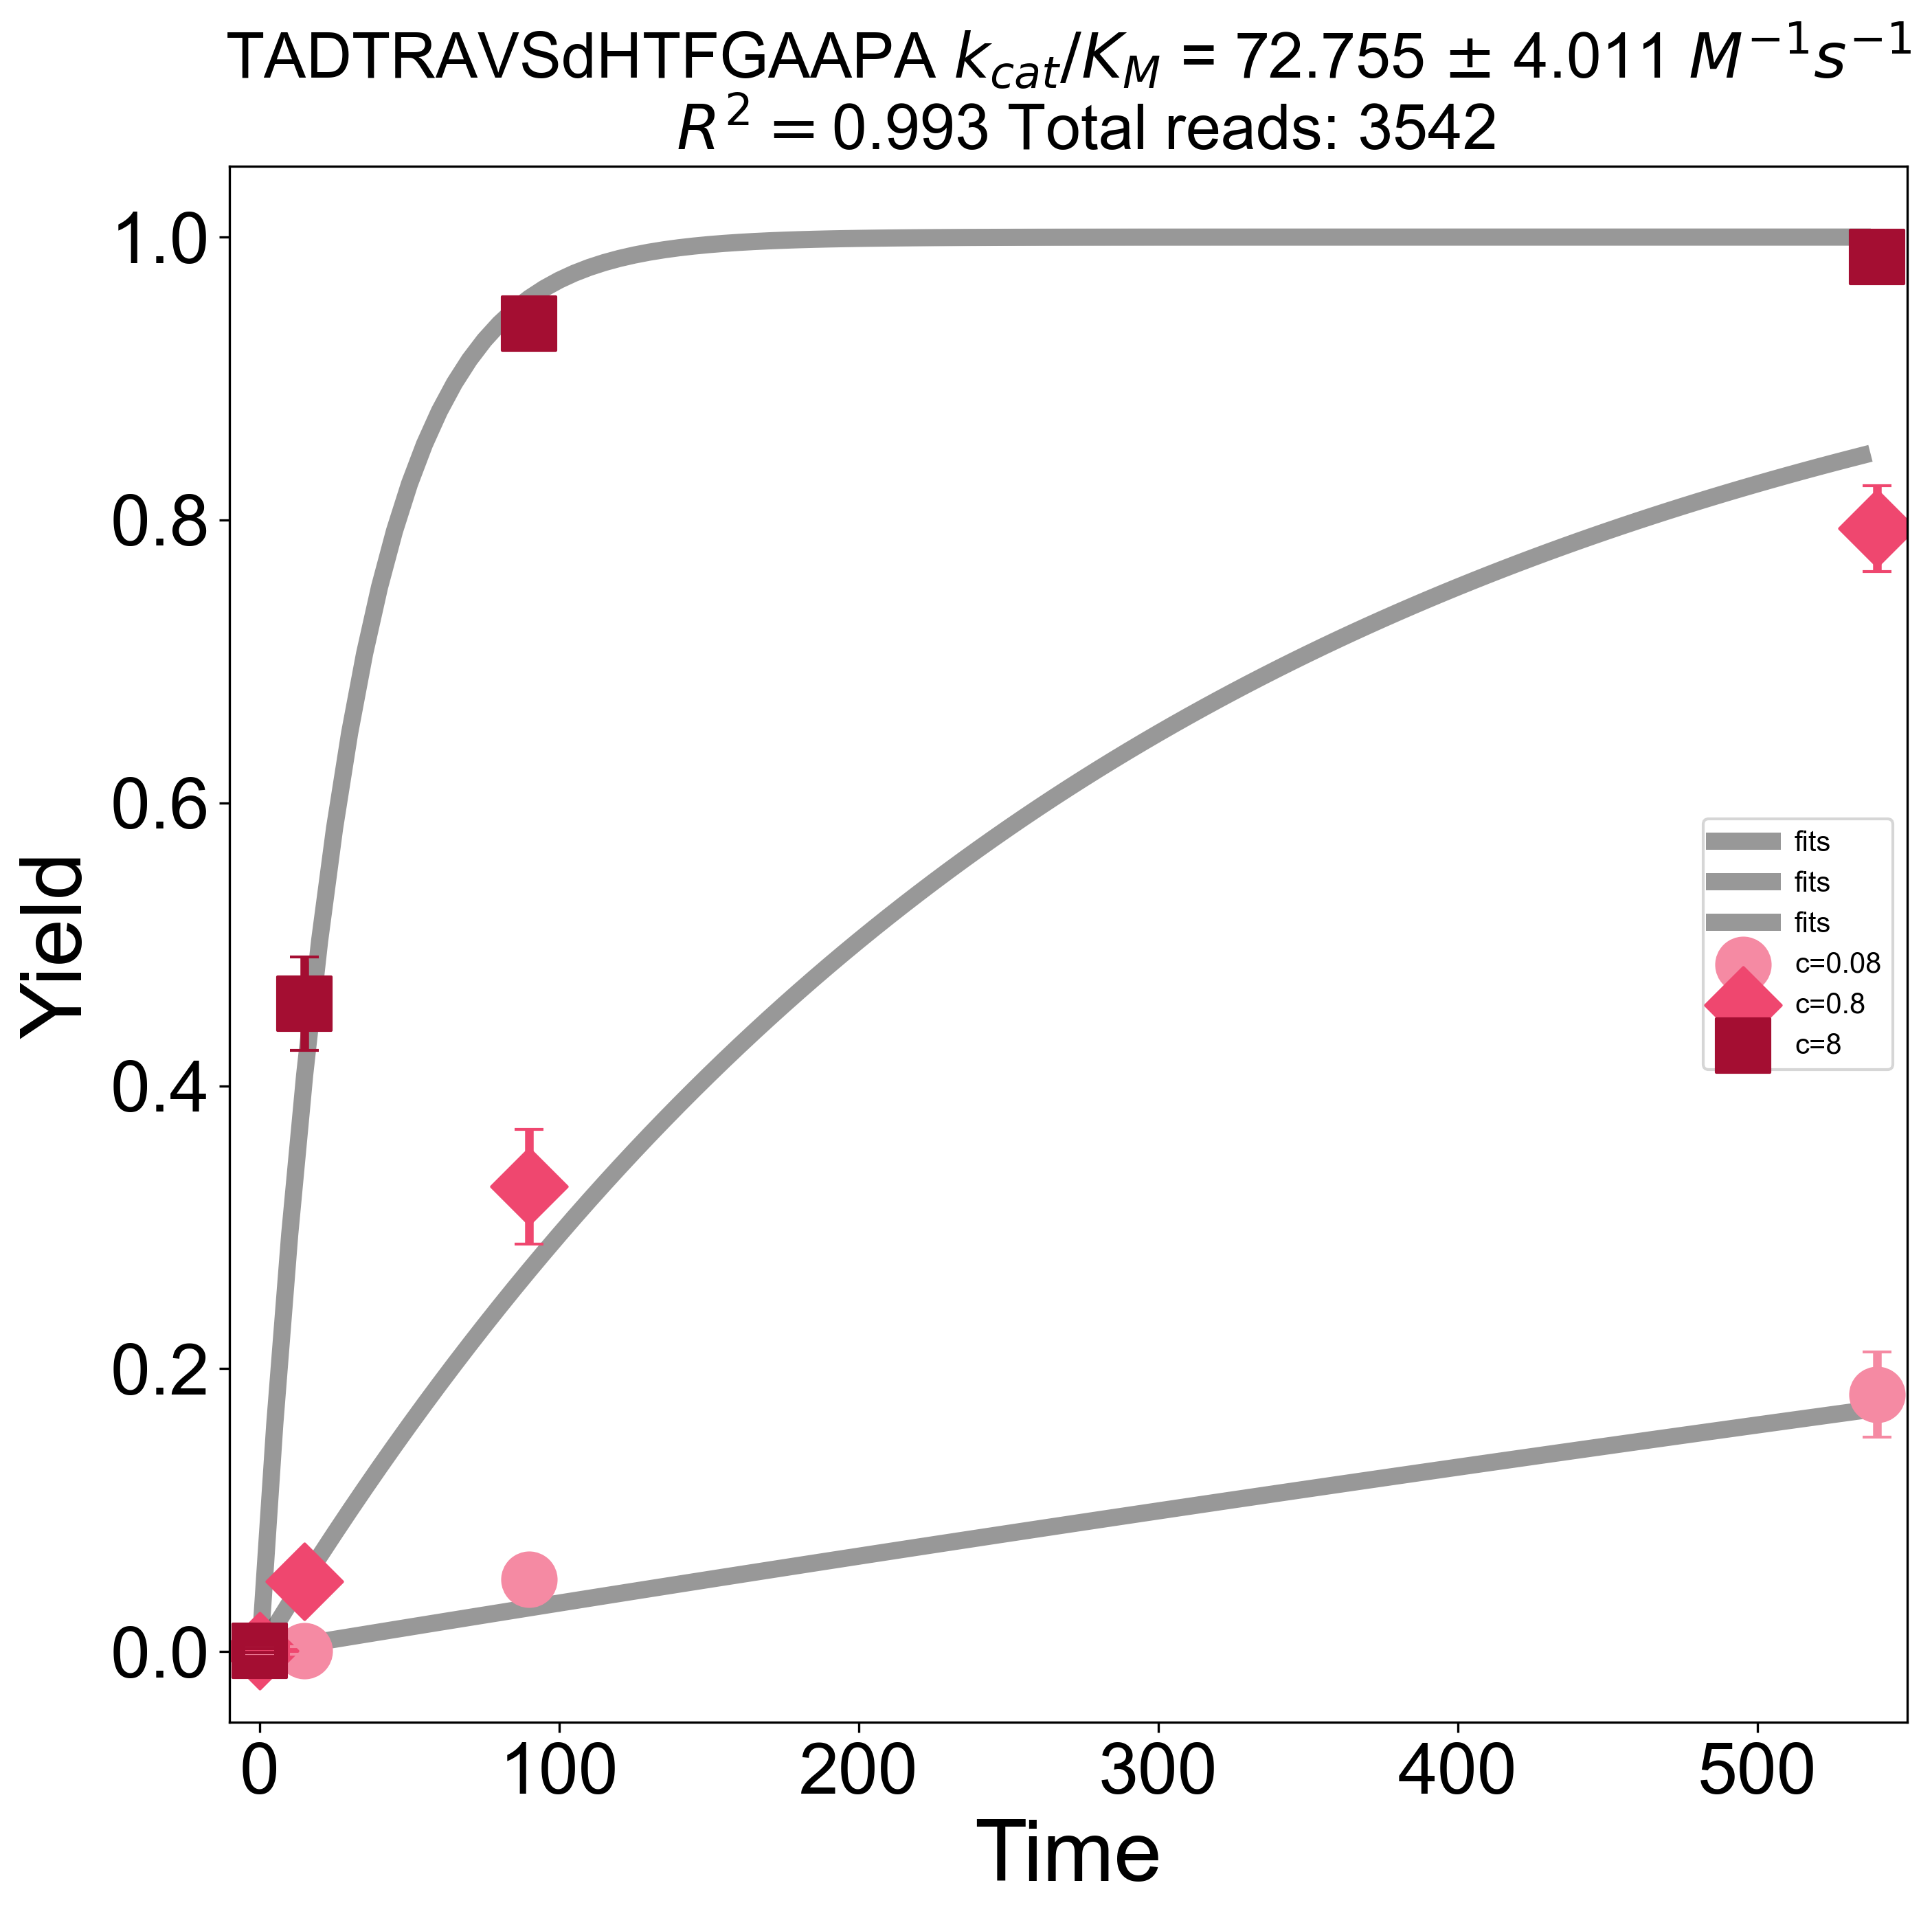

In [14]:
from DOMEK_plots import plot_peptide_fits

S = pd.read_csv('../kinetics fitting/20250501_DOMEK_master_kinetic_summary.csv')
C = pd.read_csv('../sample dataframes/DOMEK_master_list_pep.csv')     

#make a folder to write outputs in
if not os.path.isdir('../figs'):
    os.makedirs('../figs')  

pep = 'TADTRAVSdHTFGAAPA'
plot_peptide_fits(S, 
                  C,
                  pep=pep,
                  fit='1p',
                  corrected=True,
                  basename=f'../figs/20250502_{pep}_fitting'
)

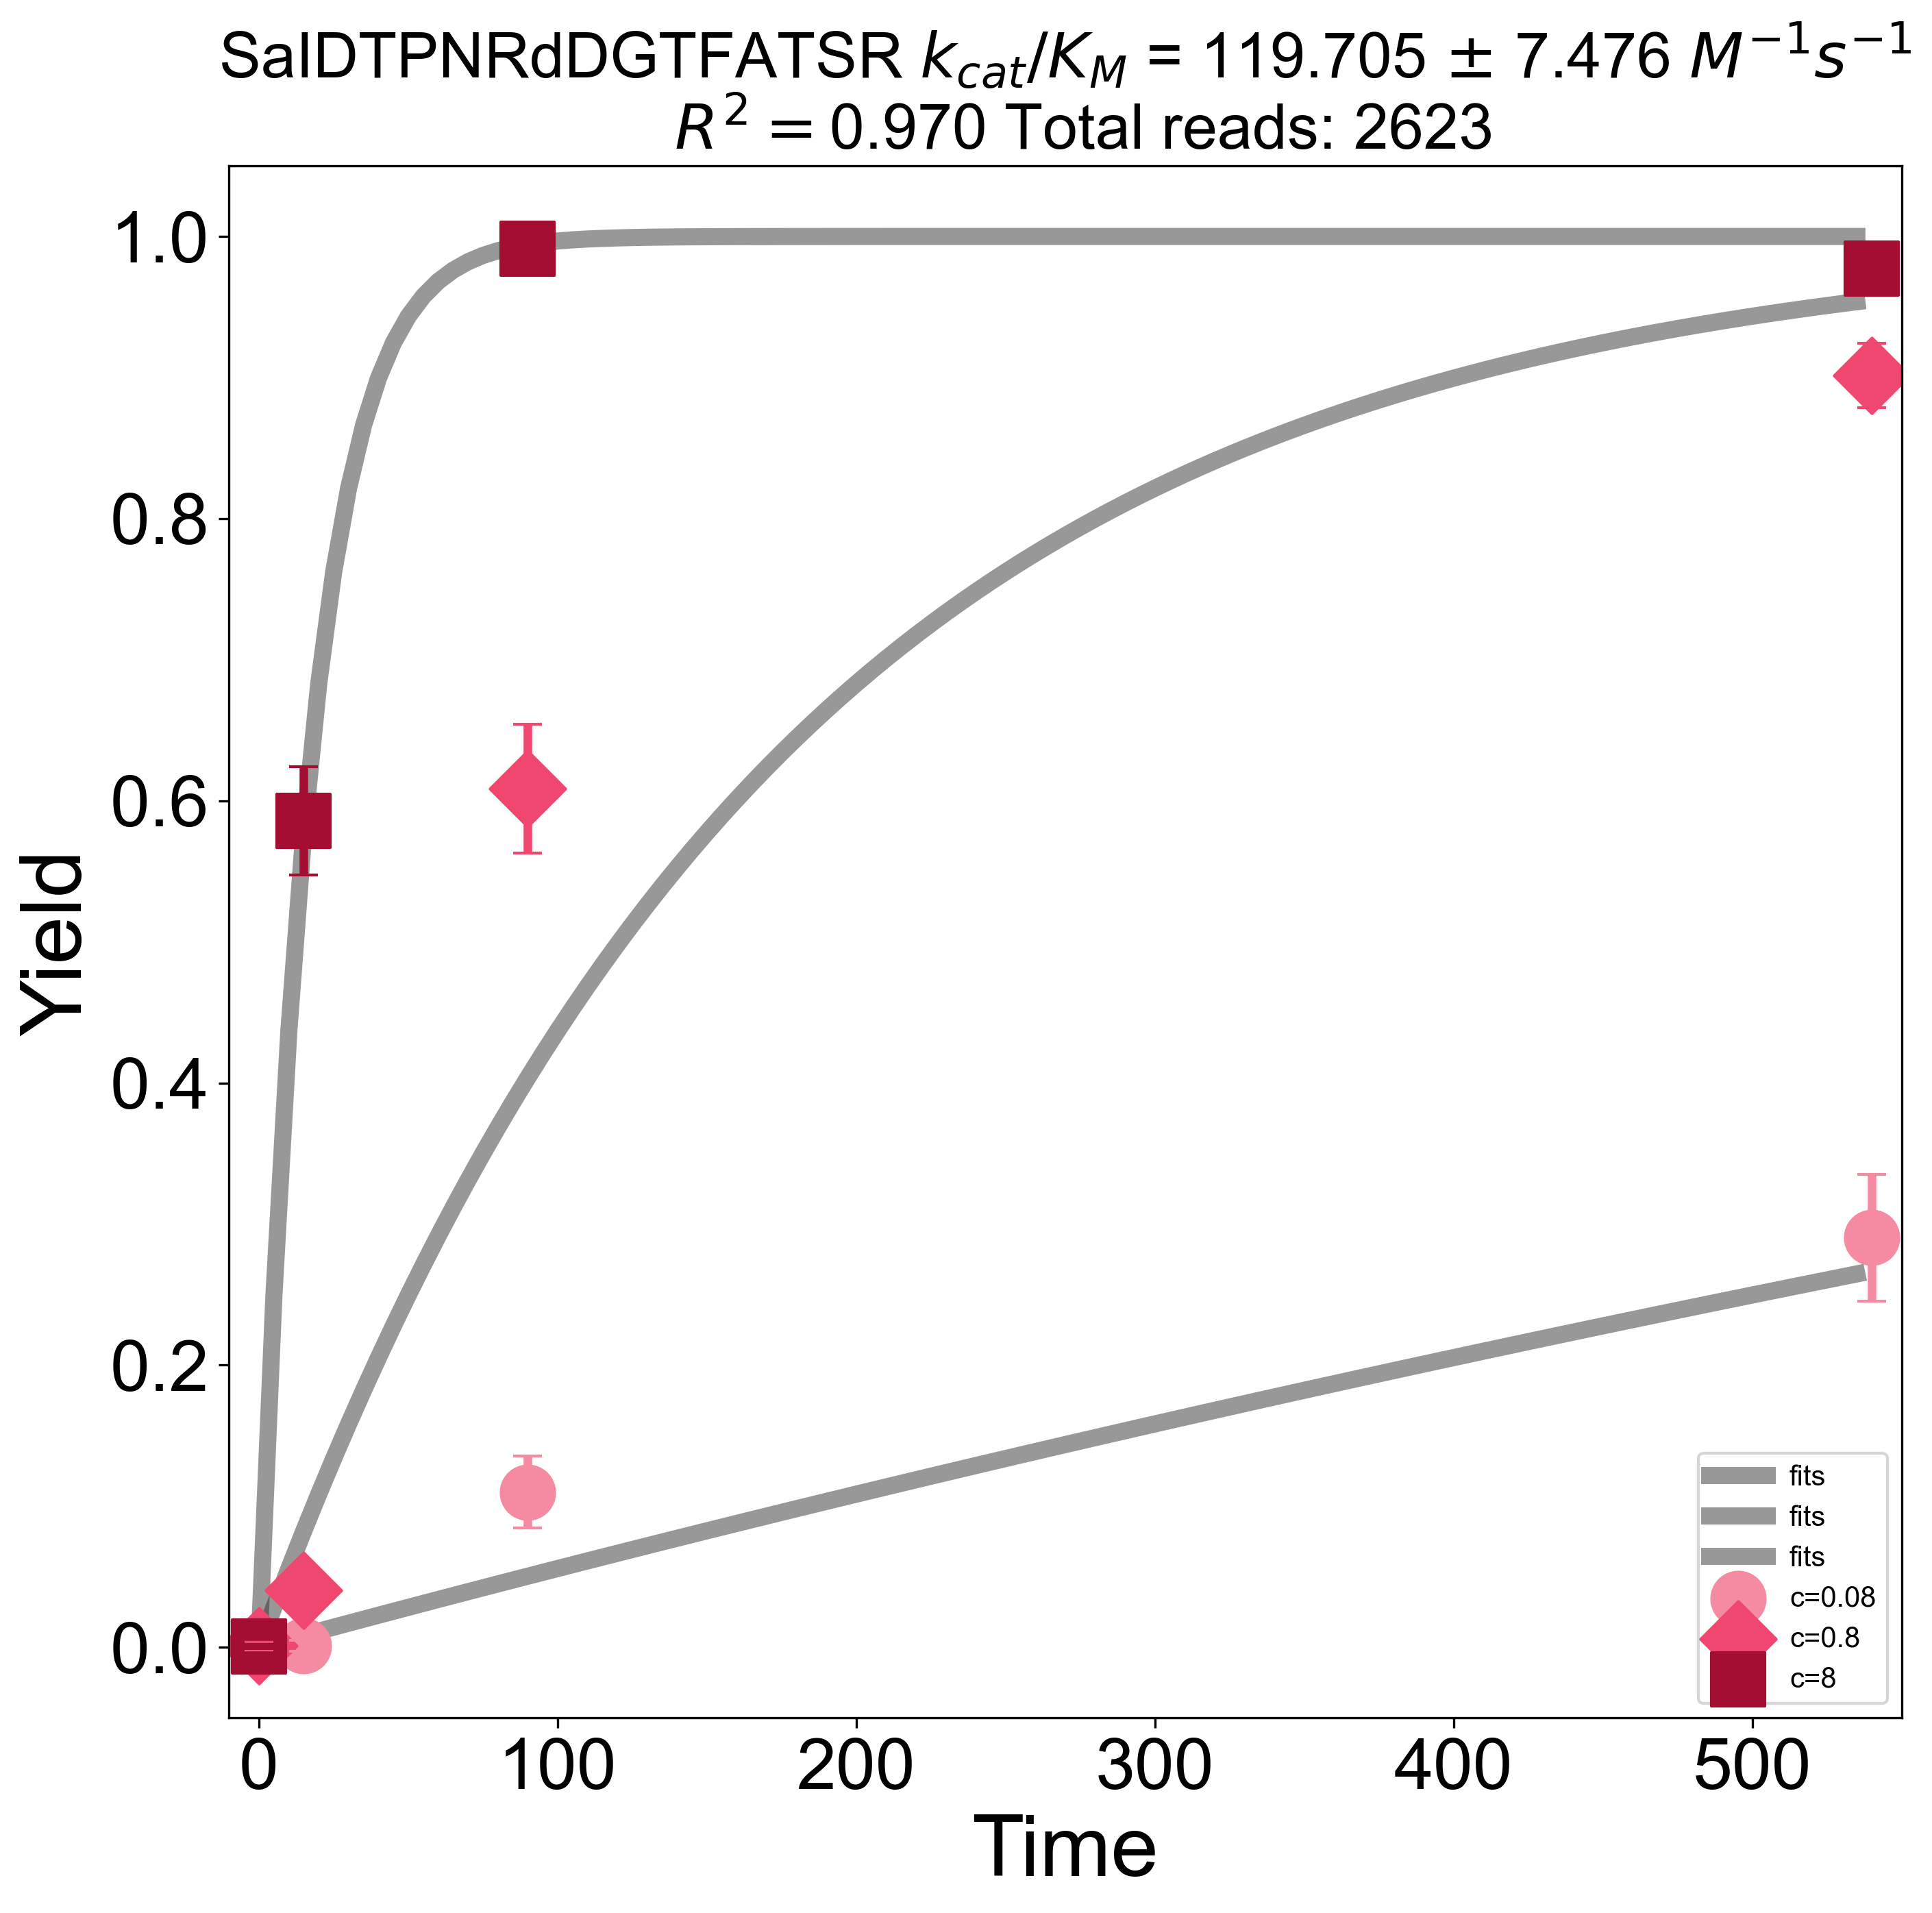

In [15]:
pep = 'SaIDTPNRdDGTFATSR' #peptide from Fig. 6d and S7
plot_peptide_fits(S, 
                  C,
                  pep=pep,
                  fit='1p',
                  corrected=True,
                  basename=f'../figs/20250502_{pep}_fitting'
)

<h3>Prepare the data for RFA model fitting</h3>

Now let's build a second-order RFA model using the k<sub>cat</sub>/K<sub>M</sub> fitted above. First, we need to prepare the data by a) retaining only high quality fits, and b) converting k<sub>cat</sub>/K<sub>M</sub> values to ΔG<sup>‡</sup>.

In [16]:
#IMPORTANT HYPERPARAMS

x_ind = [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16]
alphabet = np.array(('A', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
                     'N', 'P', 'R', 'S', 'T', 'V', 'W', 'Y', 'a'))
n_pos = len(x_ind)
n_aas = len(alphabet)

MIN_KK = 0.5
MAX_KK = 30000
MIN_READS = 200
MAX_ERR = 0.30
MIN_R2 = 0.83

In [17]:
#load the data
S = pd.read_csv('../kinetics fitting/20250501_DOMEK_succint_kinetic_summary.csv')

#get rid of peptides with less than MIN_READS reads
S = S[S['tot_count'] > MIN_READS]

#make sure the error is low OR we are outside of the dynamic range
#(in other words, the peptides outside the dynamic range are allowed to have high errors)
ind1 = S['kcat/Km_1p_err'] / S['kcat/Km_1p'] < MAX_ERR
ind2 = S['kcat/Km_1p'] < MIN_KK
ind3 = S['kcat/Km_1p'] > MAX_KK
S = S[ind1 | ind2 | ind3]

#make sure that the R_sq is high enough OR we are outside of the dynamic range
ind1 = S['1param R_2_adj'] > MIN_R2
ind2 = S['kcat/Km_1p'] < MIN_KK
ind3 = S['kcat/Km_1p'] > MAX_KK
S = S[ind1 | ind2 | ind3]

#make sure no dxxH motifs are used for training
#this is a heuristic based on our prior observation
#of unpredictable reactivity in dxxH peptides
#refer to JACS 2024, 146, 31124–31136
S = S[~S['seq'].apply(lambda x: x[11] == 'H')]

#flatten kcat/Km values
S['kcat/Km_1p'][S['kcat/Km_1p'] < MIN_KK] = MIN_KK
S['kcat/Km_1p'][S['kcat/Km_1p'] > MAX_KK] = MAX_KK

#this another empirical exclusion: some peptides which appear to be 
#modified well, e.g., non-enzymatically, are excluded from further analysis
S = S[~((S['pos_count'] / S['neg_count'] > 2) & (S['kcat/Km_1p'] < 1))]

#convert kcat/Km to dG values
from DOMEK import kcatKm_to_dG
y = kcatKm_to_dG(S['kcat/Km_1p'])

#zero-offset normalize the values
print(f'ΔG‡ offset: {y.min():.3f}')
y = y - y.min()

ΔG‡ offset: 11.338


Now we need to featurize peptide sequences for use in RFA regression:

In [18]:
data = Data([AnalysisSample(X=S['seq'], 
                            y=y,
                            seq=S['seq'])
]
)
#this is to remove the fixed Dha that does not
#contribute to the decomposition
data[0].X = data[0].X[:,x_ind]

pip.enque([         
            pre.int_repr(alphabet=alphabet),
            pre.shuffle(),
            pre.tt_split(test_fraction=0.01),
            pre.featurize_for_RFA(alphabet=alphabet, order='second')
]
)

data = pip.run(data)

#prep the data
X_train = data[0].X
y_train = data[0].y

X_test = data[1].X
y_test = data[1].y

inp_dim = X_train.shape[-1]

[INFO]: 4 ops appended to pipeline; current queue size: 4
[INFO]: unnamed X dataset shape: (178997, 16)
[INFO]: unnamed y dataset shape: (178997,)
[INFO]: unnamed seq dataset shape: (178997,)
[INFO]: -----------------------------------------------------------------
[INFO]: Queuing <X_as_int> op. . .
[INFO]: The operation took 0.082 s
[INFO]: unnamed X dataset shape: (178997, 16)
[INFO]: unnamed y dataset shape: (178997,)
[INFO]: unnamed seq dataset shape: (178997,)
[INFO]: -----------------------------------------------------------------
[INFO]: Queuing <shuffle_intraset> op. . .
[INFO]: The operation took 0.017 s
[INFO]: unnamed X dataset shape: (178997, 16)
[INFO]: unnamed y dataset shape: (178997,)
[INFO]: unnamed seq dataset shape: (178997,)
[INFO]: -----------------------------------------------------------------
[INFO]: Queuing <test_train_split> op. . .
[INFO]: The operation took 0.089 s
[INFO]: train_data X dataset shape: (177208, 16)
[INFO]: train_data y dataset shape: (177208

<h3>Initialize an RFA model and fit it</h3>

In [19]:
from RFA import initialize_RFA_model

#initialize the model
model = initialize_RFA_model(inp_dim, 
                             max_y=y.max(),
                             L1_reg=0.00008,
                             LR_schedule=None, #will use the default (Exponential decay)
                             optimizer=None #will use the default (Adam)
)

#setup callbacks
from tf.callbacks import EarlyStop, Checkpoint

save_dir = '../tf_trained_models'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)  

model_name = '20250502_chkpt_best.h5'
filepath = os.path.join(save_dir, model_name)

callbacks = [
             EarlyStop(patience=12), 
             Checkpoint(filepath=filepath, save_best_only=True),
]

#fit
training_log = model.fit(
                         x=X_train,
                         y=y_train,
                         batch_size=128,
                         epochs=1024,            
                         validation_data=(X_test, y_test),
                         callbacks=callbacks,
                         verbose=1
)

Epoch 1/1024
1385/1385 [==============================] - 12s 8ms/step - loss: 3.4806 - r2_score: 0.4488 - val_loss: 0.4415 - val_r2_score: 0.9482

Epoch 00001: val_loss improved from inf to 0.44154, saving model to ../tf_trained_models\20250502_chkpt_best.h5
Epoch 2/1024
1385/1385 [==============================] - 10s 7ms/step - loss: 0.3795 - r2_score: 0.9585 - val_loss: 0.3888 - val_r2_score: 0.9574

Epoch 00002: val_loss improved from 0.44154 to 0.38880, saving model to ../tf_trained_models\20250502_chkpt_best.h5
Epoch 3/1024
1385/1385 [==============================] - 10s 7ms/step - loss: 0.3347 - r2_score: 0.9662 - val_loss: 0.3795 - val_r2_score: 0.9589

Epoch 00003: val_loss improved from 0.38880 to 0.37954, saving model to ../tf_trained_models\20250502_chkpt_best.h5
Epoch 4/1024
1385/1385 [==============================] - 10s 7ms/step - loss: 0.3186 - r2_score: 0.9687 - val_loss: 0.3642 - val_r2_score: 0.9611

Epoch 00004: val_loss improved from 0.37954 to 0.36416, saving m

Epoch 35/1024
1385/1385 [==============================] - 10s 7ms/step - loss: 0.2594 - r2_score: 0.9722 - val_loss: 0.3115 - val_r2_score: 0.9638

Epoch 00035: val_loss did not improve from 0.30876
Epoch 36/1024
1385/1385 [==============================] - 10s 7ms/step - loss: 0.2573 - r2_score: 0.9725 - val_loss: 0.3101 - val_r2_score: 0.9640

Epoch 00036: val_loss did not improve from 0.30876
Epoch 37/1024
1385/1385 [==============================] - 10s 7ms/step - loss: 0.2568 - r2_score: 0.9725 - val_loss: 0.3066 - val_r2_score: 0.9644

Epoch 00037: val_loss improved from 0.30876 to 0.30656, saving model to ../tf_trained_models\20250502_chkpt_best.h5
Epoch 38/1024
1385/1385 [==============================] - 10s 7ms/step - loss: 0.2567 - r2_score: 0.9724 - val_loss: 0.3077 - val_r2_score: 0.9642

Epoch 00038: val_loss did not improve from 0.30656
Epoch 39/1024
1385/1385 [==============================] - 10s 7ms/step - loss: 0.2555 - r2_score: 0.9725 - val_loss: 0.3052 - val_r2_s

1385/1385 [==============================] - 10s 7ms/step - loss: 0.2441 - r2_score: 0.9732 - val_loss: 0.2967 - val_r2_score: 0.9648

Epoch 00072: val_loss did not improve from 0.29435
Epoch 73/1024
1385/1385 [==============================] - 10s 7ms/step - loss: 0.2446 - r2_score: 0.9731 - val_loss: 0.2980 - val_r2_score: 0.9646

Epoch 00073: val_loss did not improve from 0.29435
Epoch 74/1024
1385/1385 [==============================] - 10s 7ms/step - loss: 0.2441 - r2_score: 0.9732 - val_loss: 0.2959 - val_r2_score: 0.9649

Epoch 00074: val_loss did not improve from 0.29435
Epoch 75/1024
1385/1385 [==============================] - 10s 7ms/step - loss: 0.2429 - r2_score: 0.9734 - val_loss: 0.2944 - val_r2_score: 0.9651

Epoch 00075: val_loss did not improve from 0.29435
Epoch 76/1024
1385/1385 [==============================] - 10s 7ms/step - loss: 0.2427 - r2_score: 0.9734 - val_loss: 0.2969 - val_r2_score: 0.9647

Epoch 00076: val_loss did not improve from 0.29435
Epoch 77/1024


1385/1385 [==============================] - 10s 7ms/step - loss: 0.2373 - r2_score: 0.9738 - val_loss: 0.2934 - val_r2_score: 0.9648

Epoch 00111: val_loss did not improve from 0.29176
Epoch 112/1024
1385/1385 [==============================] - 10s 7ms/step - loss: 0.2362 - r2_score: 0.9741 - val_loss: 0.2912 - val_r2_score: 0.9652

Epoch 00112: val_loss improved from 0.29176 to 0.29121, saving model to ../tf_trained_models\20250502_chkpt_best.h5
Epoch 113/1024
1385/1385 [==============================] - 10s 7ms/step - loss: 0.2366 - r2_score: 0.9739 - val_loss: 0.2914 - val_r2_score: 0.9651

Epoch 00113: val_loss did not improve from 0.29121
Epoch 114/1024
1385/1385 [==============================] - 10s 7ms/step - loss: 0.2366 - r2_score: 0.9739 - val_loss: 0.2927 - val_r2_score: 0.9649

Epoch 00114: val_loss did not improve from 0.29121
Epoch 115/1024
1385/1385 [==============================] - 10s 7ms/step - loss: 0.2366 - r2_score: 0.9739 - val_loss: 0.2933 - val_r2_score: 0.96

Model weights can now be renormalized:

In [20]:
#accuracy of predictions before renormalization:
r2 = np.corrcoef((model.predict(data[1].X).ravel(), data[1].y))**2
print(f'predictions before renormalization: {r2[0,1]:.4f}')

W = model.get_weights()

from RFA import weight_renormalization
renorm_W = weight_renormalization(W, n_pos, n_aas)
model.set_weights(renorm_W)

#accuracy of predictions after renormalization:
r2 = np.corrcoef((model.predict(data[1].X).ravel(), data[1].y))**2
print(f'predictions after renormalization: {r2[0,1]:.4f}')

predictions before renormalization: 0.9655
predictions after renormalization: 0.9655


As can be seen above, renormalization does not alter model predictions. Let's now inspect fitted model weights, like in Fig. 6a and 6b in the manuscript.

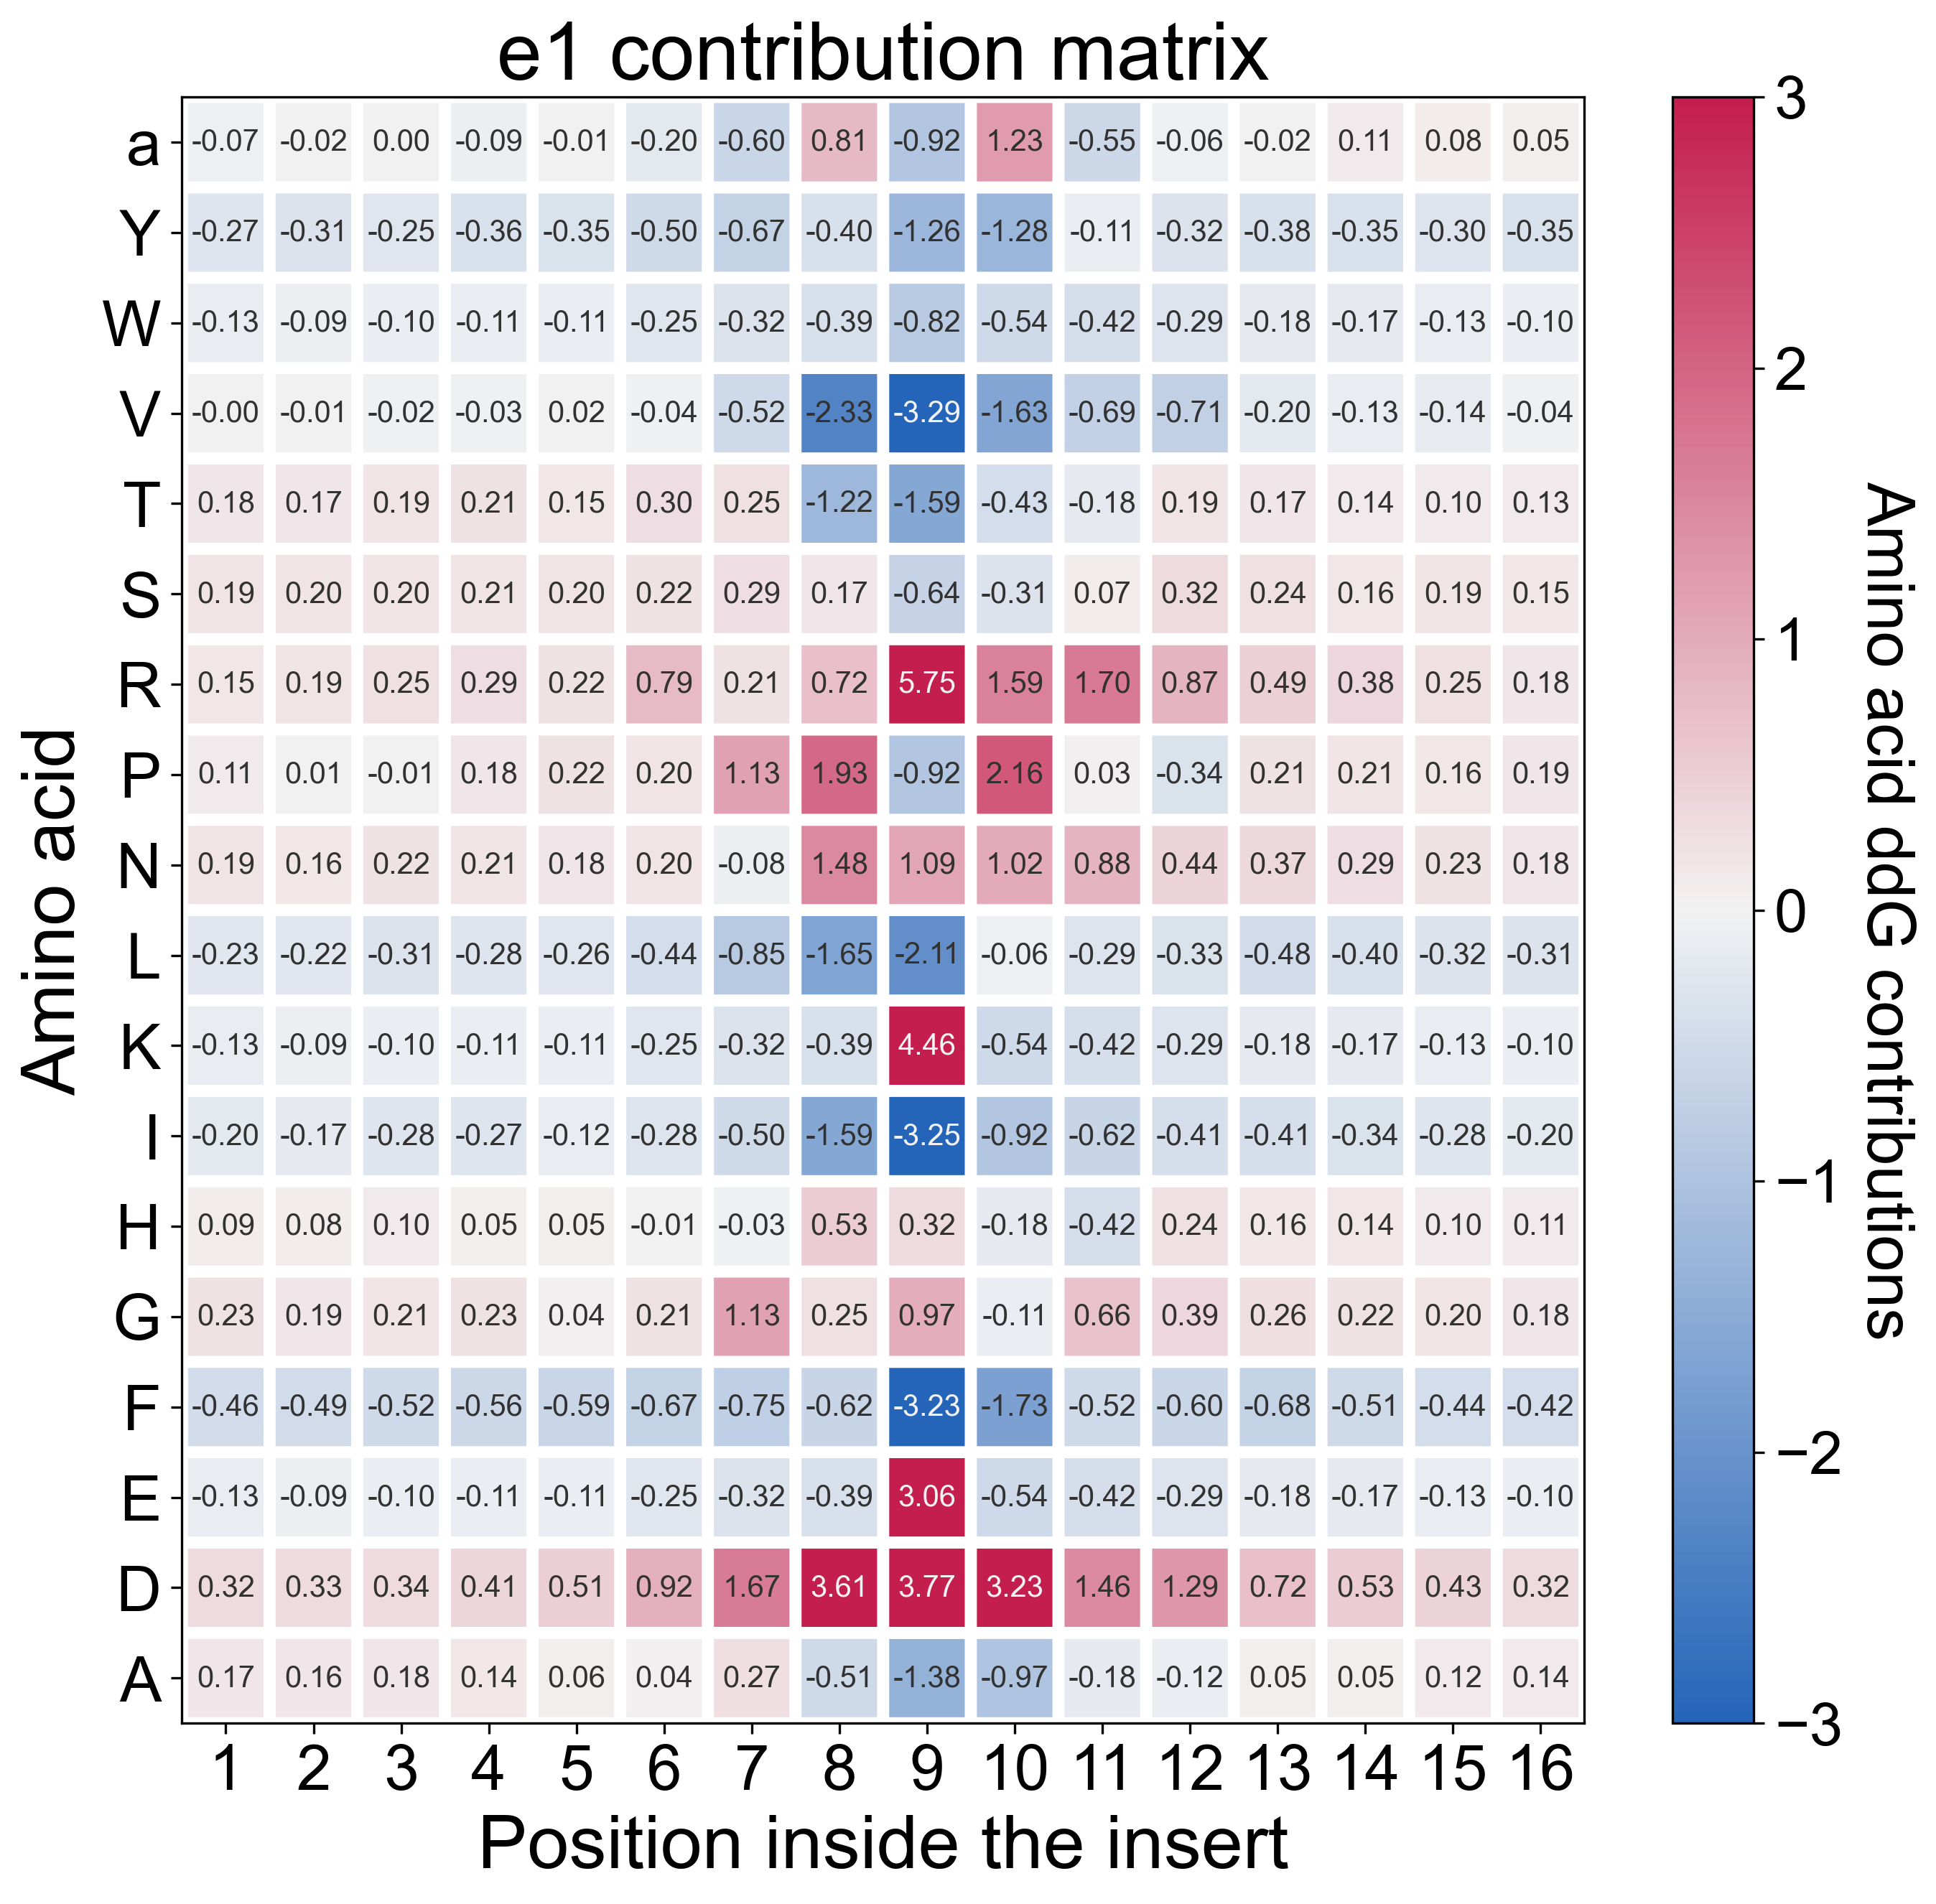

In [21]:
from RFA import parse_W_matrix

W = model.get_weights()
e0, e1, e2 = parse_W_matrix(W, n_pos, n_aas)

from RFA_plots import plot_e1_tensor
plot_e1_tensor(e1.T, alphabet, '../figs/RFA_20250502_renorm_e1', scale=3)

In a renormalized first-order term matrix, the sum of all contributions for a given position should be equal to 0:

In [22]:
e1.sum(axis=1)

array([ 0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0., -0., -0.,
        0., -0.,  0.], dtype=float32)

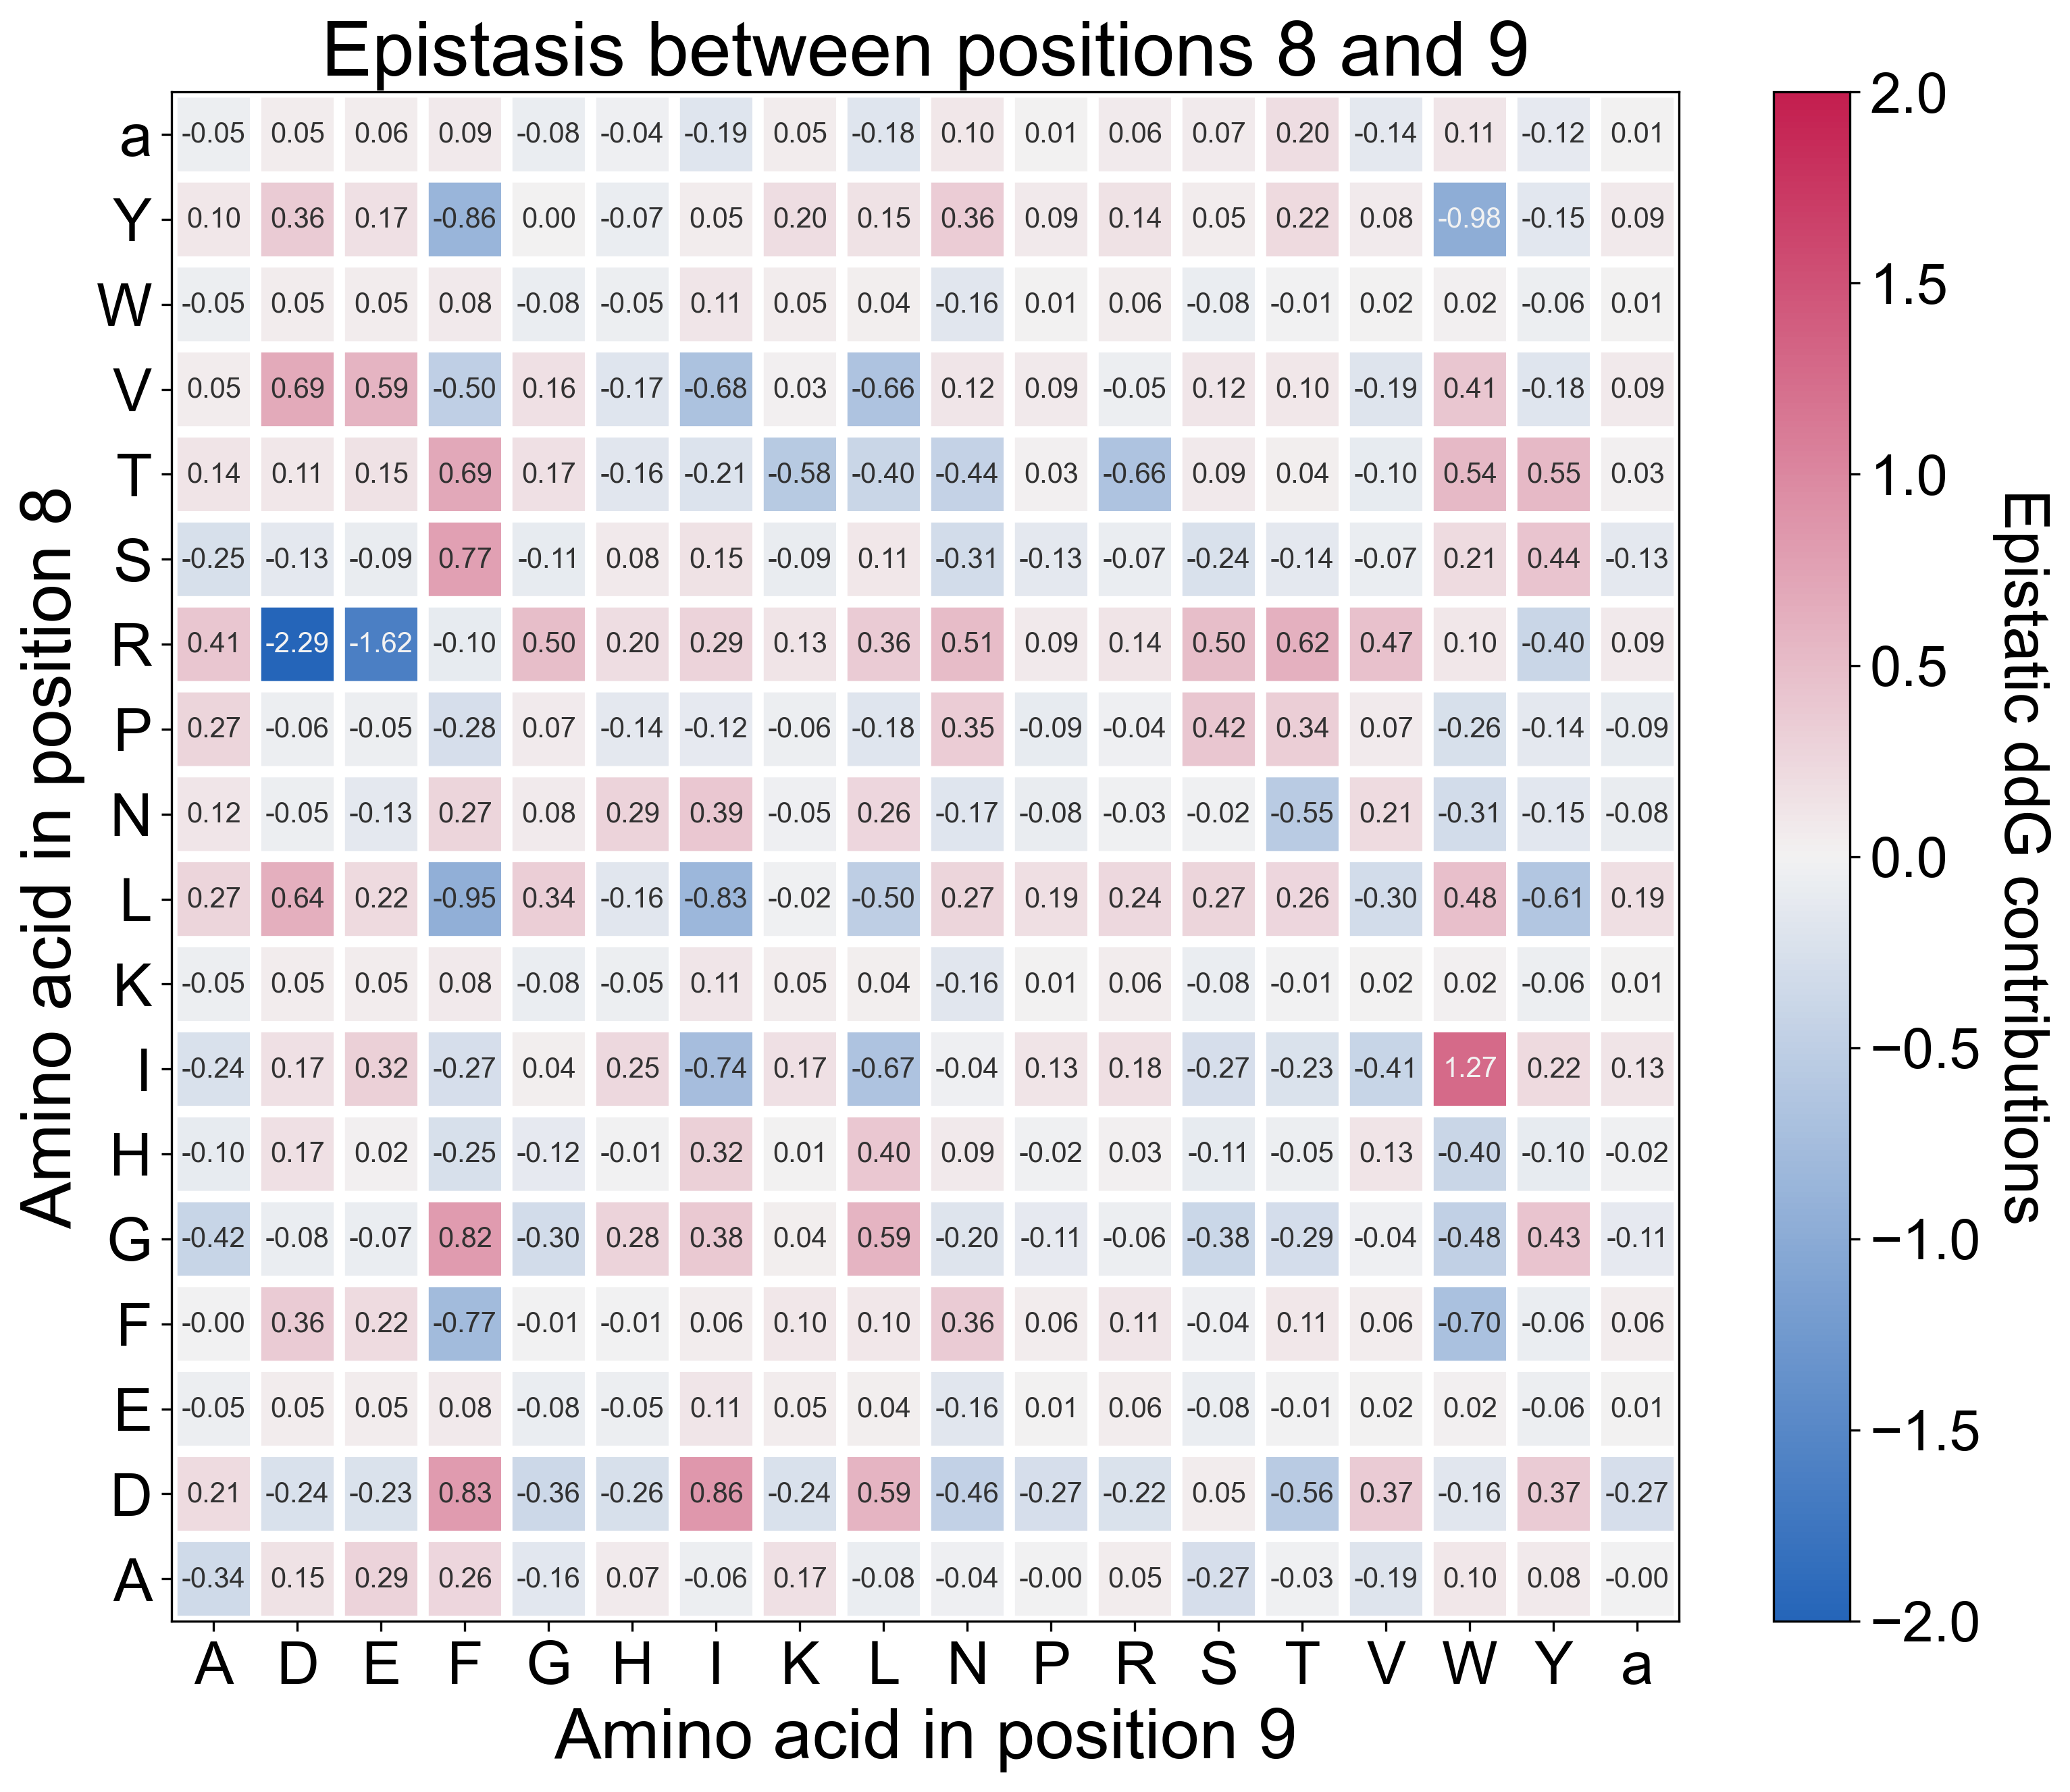

In [23]:
from RFA_plots import plot_e2_tensor_slice

#for the second-order terms, let's plot the epistasis between positions 8 and 10, analogous to Fig. 6b
plot_e2_tensor_slice(e2, 7, 8, alphabet, '../figs/RFA_20250502_renorm_e2_pos8_10', scale=2)

RFA model weights used in the manuscript are available in `../tf_trained_models/RFA_20250124_zero_mean.h5`.
They can be loaded directly:

In [24]:
model = initialize_RFA_model(inp_dim, 
                             max_y=y.max(),
                             L1_reg=0.00008
)
model.load_weights('../tf_trained_models/RFA_20250124_zero_mean.h5')

Convolutional network that was used for comparison is defined in `tf/cnn_model.py`. Peptides would need to be featurized diffrently in this case:

In [25]:
from tf.cnn_model import domek_cnn

data = Data([AnalysisSample(X=S['seq'], 
                            y=y,
                            seq=S['seq'])
]
)

pip.enque([         
           pre.int_repr(alphabet=alphabet),
           pre.shuffle(),
           pre.x_expand_and_shift(new_x_dim=18),
           pre.tt_split(test_fraction=0.01),
           pre.featurize_X(F='pep_ECFP4', 
                           alphabet=pre.constants.aas,
                           reshape=True,
                           repad=False
                          )
]
)

data = pip.run(data)

#prep the data
X_train = data[0].X
y_train = data[0].y

X_test = data[1].X
y_test = data[1].y

inp_dim = X_train.shape[1:]

import tensorflow as tf
import tensorflow.keras as K
from tf.metrics import R2Score
from tf.schedules import NoamSchedule
from tf.callbacks import EarlyStop, Checkpoint

cnn = domek_cnn(inp_dim=inp_dim, drop=0.2)
LR = NoamSchedule(inp_dim[-1], warmup_steps=4000)

opt = tf.keras.optimizers.Adam(
                               learning_rate=LR,
                               beta_1=0.9,
                               beta_2=0.98, 
                               epsilon=1e-9
)

cnn.compile(optimizer=opt,
            loss=K.losses.MeanSquaredError(),
            metrics=[R2Score(), 
                     tf.keras.metrics.MeanSquaredError(name="mse")
]
)

save_dir = '../tf_trained_models'
model_name = '20250502_cnn_chkpt_best.h5'
filepath = os.path.join(save_dir, model_name)

callbacks = [
             EarlyStop(patience=8), 
             Checkpoint(filepath=filepath, save_best_only=True),
]

training_log = cnn.fit(
                       x=X_train,
                       y=y_train,
                       batch_size=256,
                       epochs=1024,            
                       validation_data=(X_test, y_test),
                       callbacks=callbacks,
                       verbose=1
)

[WARNING]: DataPreprocessor did not receive an F matrix for featurization. Featurization will result in one-hot encoding. . .
[INFO]: 5 ops appended to pipeline; current queue size: 5
[INFO]: unnamed X dataset shape: (178997, 17)
[INFO]: unnamed y dataset shape: (178997,)
[INFO]: unnamed seq dataset shape: (178997,)
[INFO]: -----------------------------------------------------------------
[INFO]: Queuing <X_as_int> op. . .
[INFO]: The operation took 0.083 s
[INFO]: unnamed X dataset shape: (178997, 17)
[INFO]: unnamed y dataset shape: (178997,)
[INFO]: unnamed seq dataset shape: (178997,)
[INFO]: -----------------------------------------------------------------
[INFO]: Queuing <shuffle_intraset> op. . .
[INFO]: The operation took 0.017 s
[INFO]: unnamed X dataset shape: (178997, 17)
[INFO]: unnamed y dataset shape: (178997,)
[INFO]: unnamed seq dataset shape: (178997,)
[INFO]: -----------------------------------------------------------------
[INFO]: Queuing <x_expand_and_pad> op. . .
[

Epoch 1/1024
693/693 [==============================] - 30s 31ms/step - loss: 7.9706 - r2_score: -0.2859 - mse: 7.9706 - val_loss: 0.8312 - val_r2_score: 0.8656 - val_mse: 0.8312

Epoch 00001: val_loss improved from inf to 0.83118, saving model to ../tf_trained_models\20250502_cnn_chkpt_best.h5
Epoch 2/1024
693/693 [==============================] - 20s 29ms/step - loss: 0.8265 - r2_score: 0.8671 - mse: 0.8265 - val_loss: 0.6286 - val_r2_score: 0.8984 - val_mse: 0.6286

Epoch 00002: val_loss improved from 0.83118 to 0.62858, saving model to ../tf_trained_models\20250502_cnn_chkpt_best.h5
Epoch 3/1024
693/693 [==============================] - 20s 30ms/step - loss: 0.5843 - r2_score: 0.9064 - mse: 0.5843 - val_loss: 0.8187 - val_r2_score: 0.8677 - val_mse: 0.8187

Epoch 00003: val_loss did not improve from 0.62858
Epoch 4/1024
693/693 [==============================] - 21s 30ms/step - loss: 0.4899 - r2_score: 0.9213 - mse: 0.4899 - val_loss: 0.5420 - val_r2_score: 0.9124 - val_mse: 0.54

693/693 [==============================] - 21s 30ms/step - loss: 0.1657 - r2_score: 0.9734 - mse: 0.1657 - val_loss: 0.1923 - val_r2_score: 0.9689 - val_mse: 0.1923

Epoch 00033: val_loss improved from 0.21577 to 0.19231, saving model to ../tf_trained_models\20250502_cnn_chkpt_best.h5
Epoch 34/1024
693/693 [==============================] - 20s 30ms/step - loss: 0.1650 - r2_score: 0.9735 - mse: 0.1650 - val_loss: 0.2248 - val_r2_score: 0.9637 - val_mse: 0.2248

Epoch 00034: val_loss did not improve from 0.19231
Epoch 35/1024
693/693 [==============================] - 20s 29ms/step - loss: 0.1613 - r2_score: 0.9741 - mse: 0.1613 - val_loss: 0.2898 - val_r2_score: 0.9532 - val_mse: 0.2898

Epoch 00035: val_loss did not improve from 0.19231
Epoch 36/1024
693/693 [==============================] - 20s 29ms/step - loss: 0.1598 - r2_score: 0.9743 - mse: 0.1598 - val_loss: 0.2456 - val_r2_score: 0.9603 - val_mse: 0.2456

Epoch 00036: val_loss did not improve from 0.19231
Epoch 37/1024
693/693

Finally, let's see how a substrate's ΔG‡ can be decomposed into the contributions from individual amino acids (like in Fig. 6c and 6d):

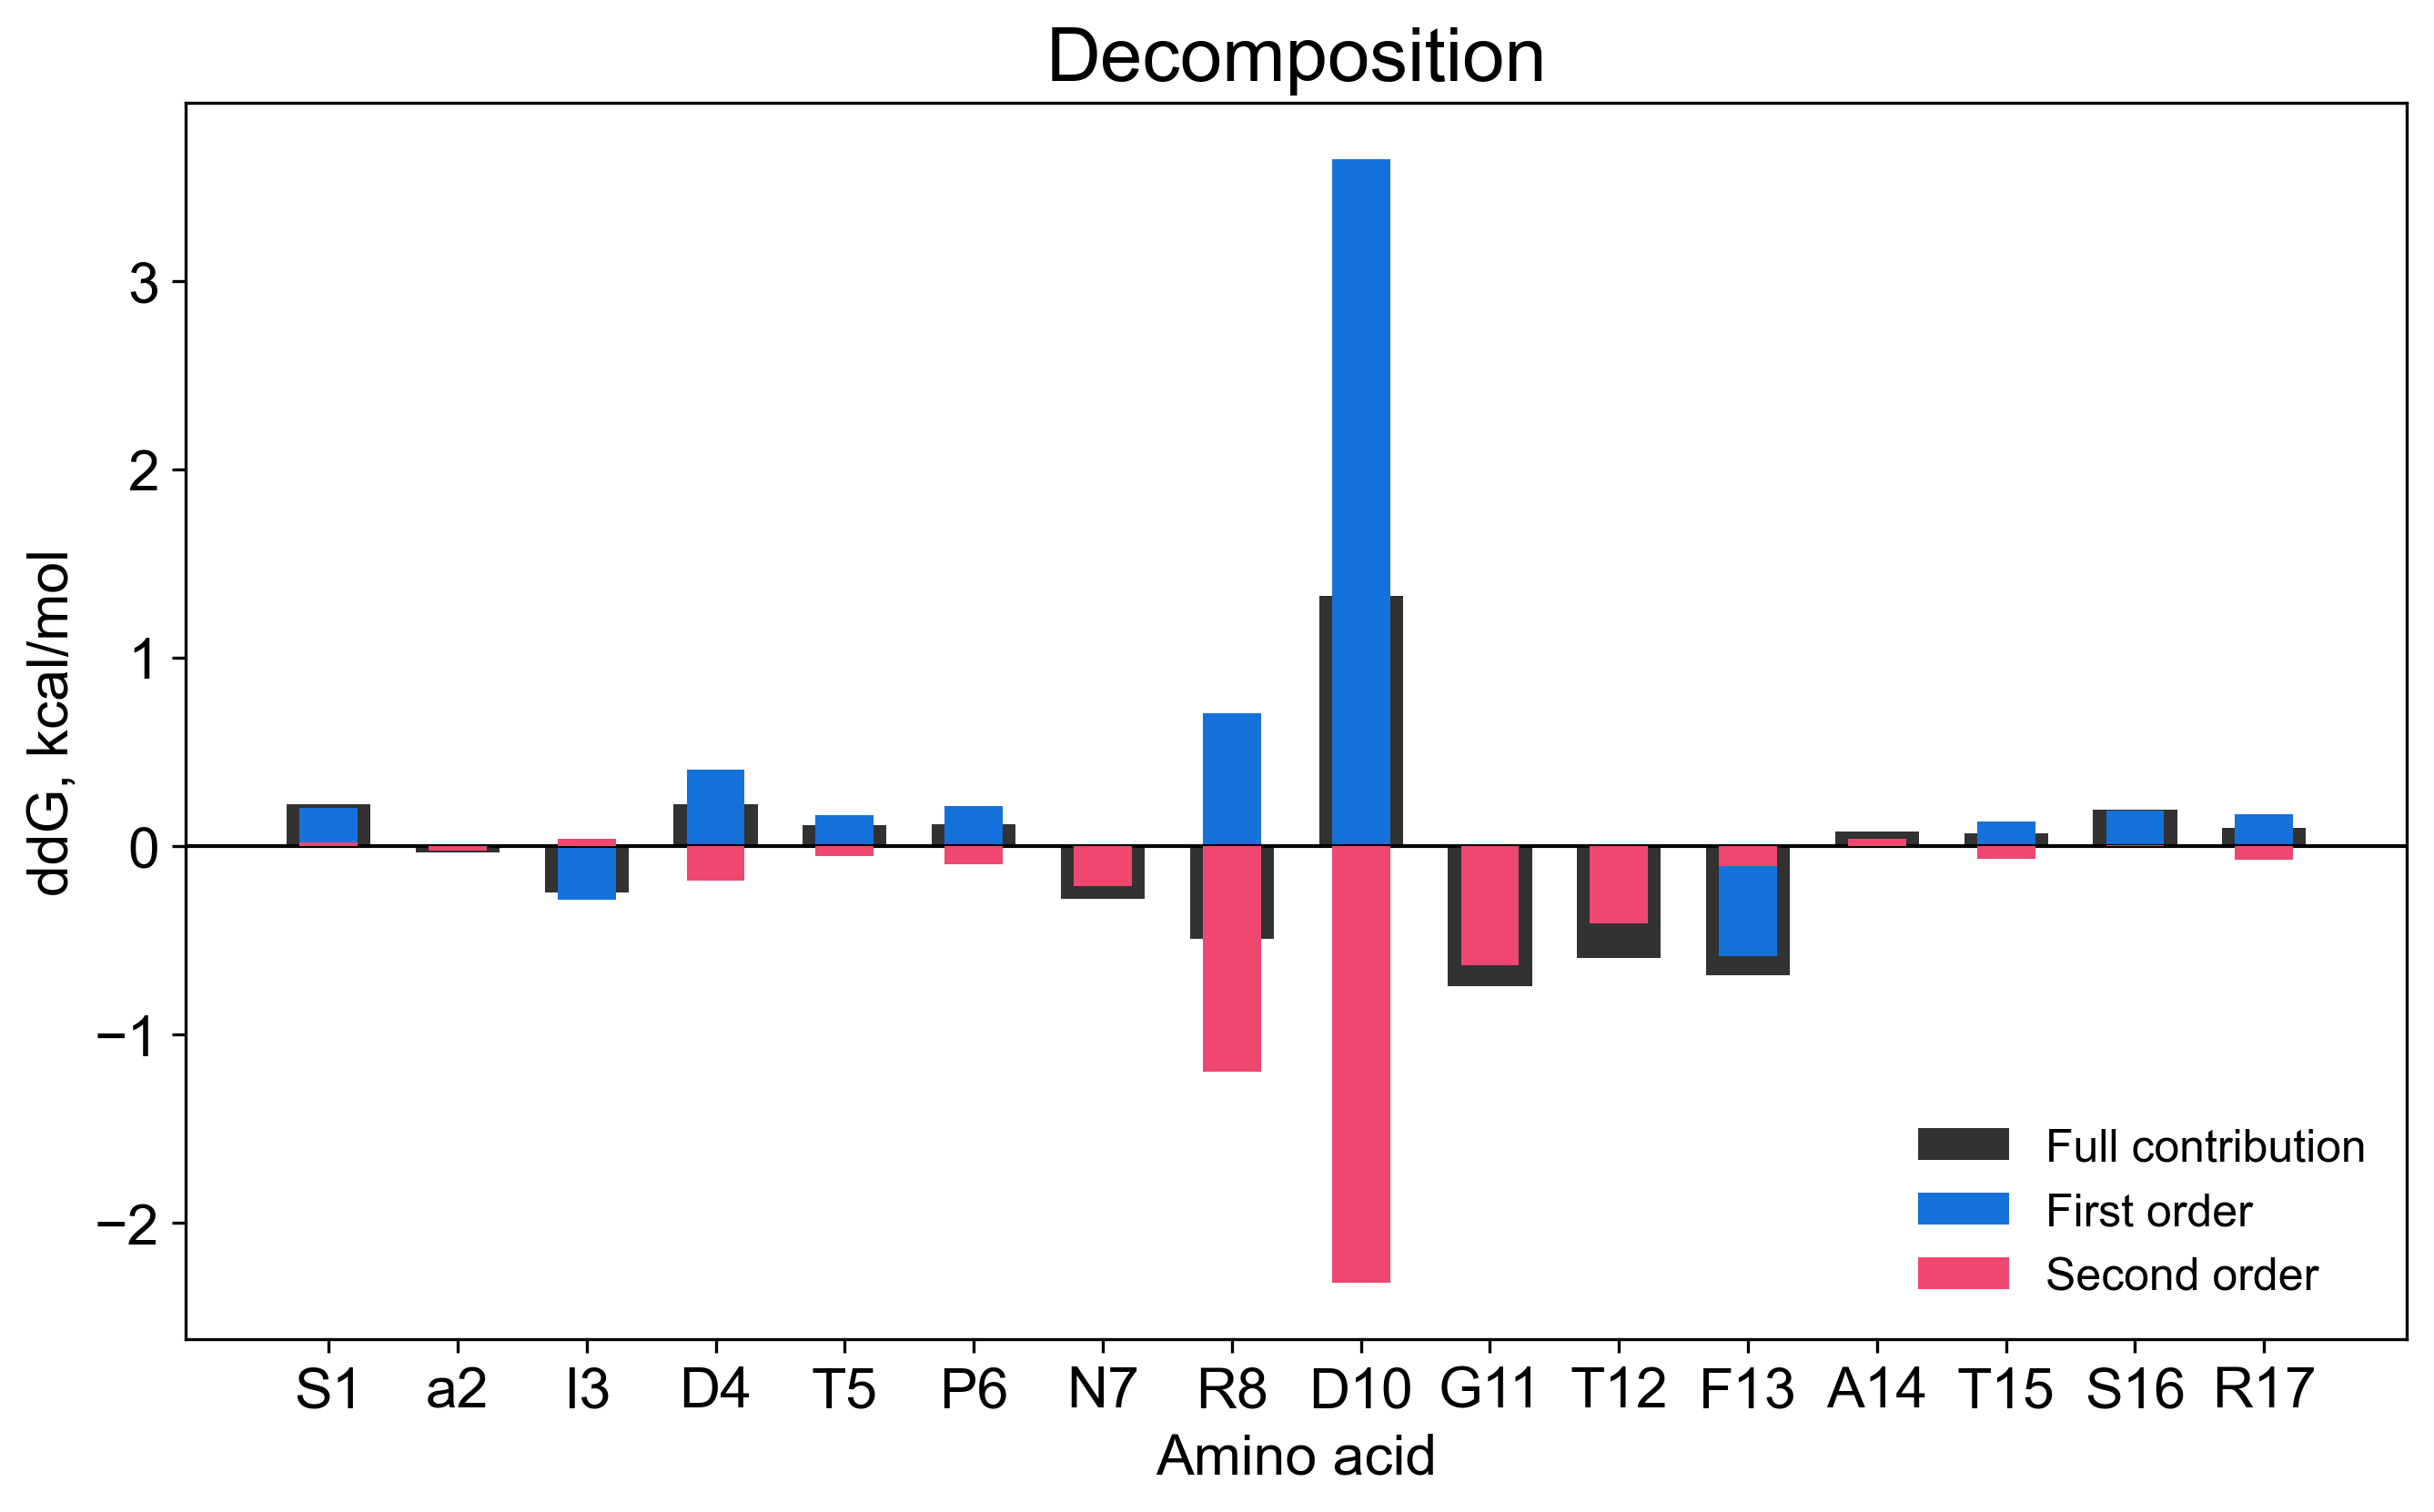

In [26]:
from RFA import pep_aa_contributions

pep = 'SaIDTPNRdDGTFATSR'
W = model.get_weights() 
e1_contr, e2_contr = pep_aa_contributions(pep, 
                                          W, 
                                          n_pos=n_pos,
                                          n_aas=n_aas,
                                          alphabet=alphabet
)

from RFA_plots import plot_aa_contributions
plot_aa_contributions(pep, e1_contr, e2_contr, alphabet, f'../figs/{pep}_decomposition')